In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import json

In [2]:
train_dirs = [
    "../experiments/all_data_cms-best-of-asha-scikit_20211025_083504_712103.workergpu007/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211025_083504_715900.workergpu006/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211025_083504_717867.workergpu020/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211025_083504_732144.workergpu010/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211025_083504_859436.workergpu036/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211026_042043_168888.workergpu007/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211026_042043_175689.workergpu036/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211026_042043_178263.workergpu010/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211026_042043_309903.workergpu020/",
    "../experiments/all_data_cms-best-of-asha-scikit_20211026_042043_311628.workergpu006/",
             ]

In [3]:
paths = []
for train_dir in train_dirs:
    paths.append(Path(train_dir))

histories = []
for path in paths:
    with open(path / "history/history.json") as h:
        histories.append(json.load(h))

for history in histories:
    reg_loss = np.sum(np.array([history["{}_loss".format(l)] for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]]), axis=0)
    val_reg_loss = np.sum(np.array([history["val_{}_loss".format(l)] for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]]), axis=0)
    history.update({"reg_loss": reg_loss})
    history.update({"val_reg_loss": val_reg_loss})    

In [4]:
def get_combined_array(key):
    combined_array = np.array(histories[0][key])
    for ii in range(1, len(histories)):
        combined_array = np.vstack([combined_array, np.array(histories[ii][key])])
    return combined_array

def plot_variance_curve(array_list, labels, skip=0, ylim=None, save_path=None):
    fig = plt.figure()
    final_means = []
    final_stds = []
    for ii, array in enumerate(array_list):
        xx = np.array(range(array.shape[1])) + 1  # Epochs

        xx = xx[skip:]
        array = array[:, skip:]

        std = np.std(array, axis=0)
        mean = np.mean(array, axis=0)

        plt.plot(xx, mean, label=labels[ii])
        plt.fill_between(xx, mean - std, mean + std, alpha=0.4)

        # Add individual loss curves
        # plt.plot(np.tile(xx, reps=[10,1]).transpose(), array.transpose(), linewidth=0.2)

        print(labels[ii] + ": {:.5f} +/- {:.5f}".format(mean[-1], std[-1]))
        final_means.append(mean[-1])
        final_stds.append(std[-1])
    
    plt.legend(bbox_to_anchor=(0.98, 0.78), loc="center right")
    plt.xlabel("Epochs")
    plt.figtext(x=0.45, y=0.53, s="Mean and standard deviation\nof {} trainings".format(array.shape[0]), fontsize=14)
    s = ""
    for ii, label in enumerate(labels):
        s += "Final {}: {:.5f} +/- {:.5f}\n".format(label.lower(), final_means[ii], final_stds[ii])
    plt.figtext(x=0.45, y=0.45, s=s, fontsize=12)
    if ylim:
        plt.ylim(top=ylim[1], bottom=ylim[0])
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [5]:
loss_array = get_combined_array("loss")
reg_loss_array = get_combined_array("reg_loss")
cls_loss_array = get_combined_array("cls_loss")

val_loss_array = get_combined_array("val_loss")
val_reg_loss_array = get_combined_array("val_reg_loss")
val_cls_loss_array = get_combined_array("val_cls_loss")

cls_acc_weighted_array = get_combined_array("cls_acc_weighted")
val_cls_acc_weighted_array = get_combined_array("val_cls_acc_weighted")

In [6]:
loss_array.shape, val_loss_array.shape

((10, 200), (10, 200))

Training loss: 0.08639 +/- 0.00403
Validation loss: 0.07846 +/- 0.00437


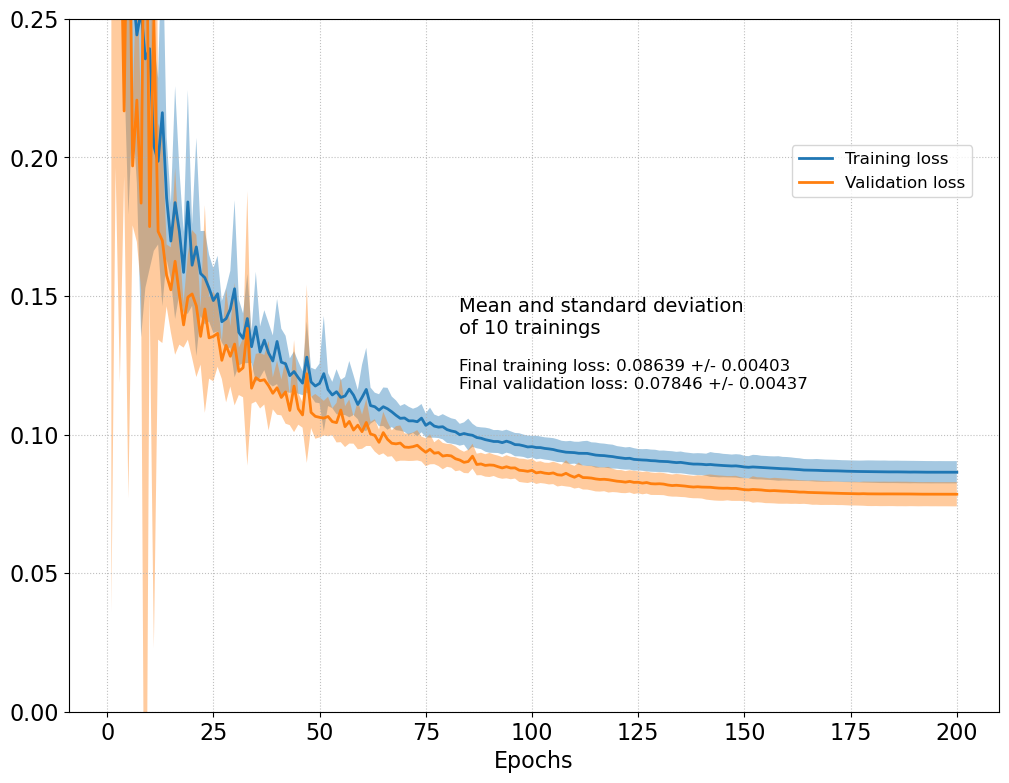

In [7]:
mpl.rc_file("my_matplotlib_rcparams")
plot_variance_curve([loss_array, val_loss_array],
                    labels=["Training loss", "Validation loss"],
                    skip=0,
                    ylim=[0.0, 0.25],
                    save_path="loss_curves_std.pdf",
                   )

Training regression loss: 0.02325 +/- 0.00107
Validation regression loss: 0.02465 +/- 0.00173


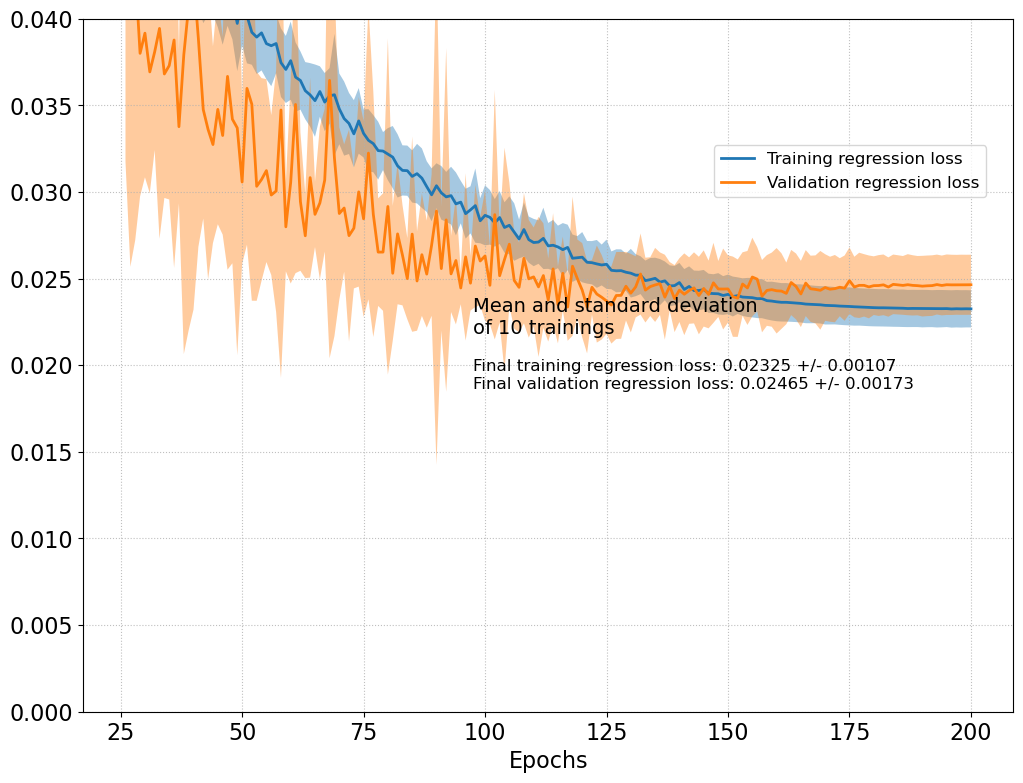

In [8]:
plot_variance_curve([reg_loss_array, val_reg_loss_array],
                    labels=["Training regression loss", "Validation regression loss"],
                    skip=25,
                    ylim=(0.0, 0.04)
                   )

Training classification loss: 0.00086 +/- 0.00004
Validation classification loss: 0.00078 +/- 0.00004


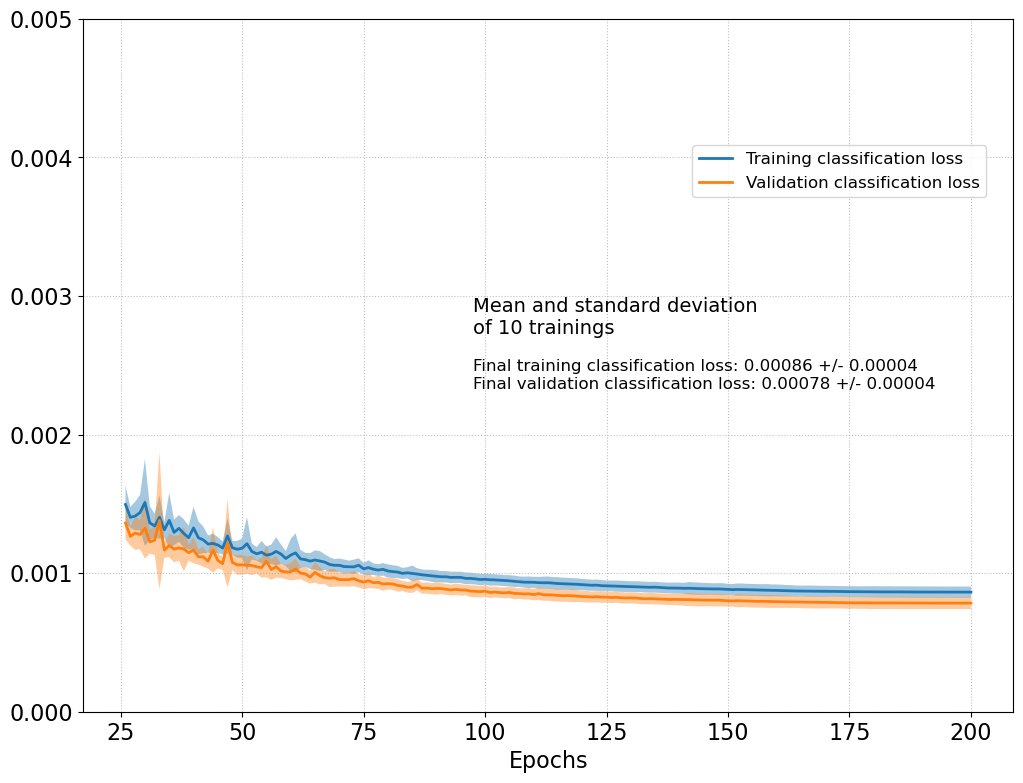

In [9]:
plot_variance_curve([cls_loss_array, val_cls_loss_array],
                    labels=["Training classification loss", "Validation classification loss"],
                    skip=25,
                    ylim=(0.0, 0.005)
                   )

Weighted train accuracy: 0.93594 +/- 0.00227
Weighted valididation accuracy: 0.93842 +/- 0.00264


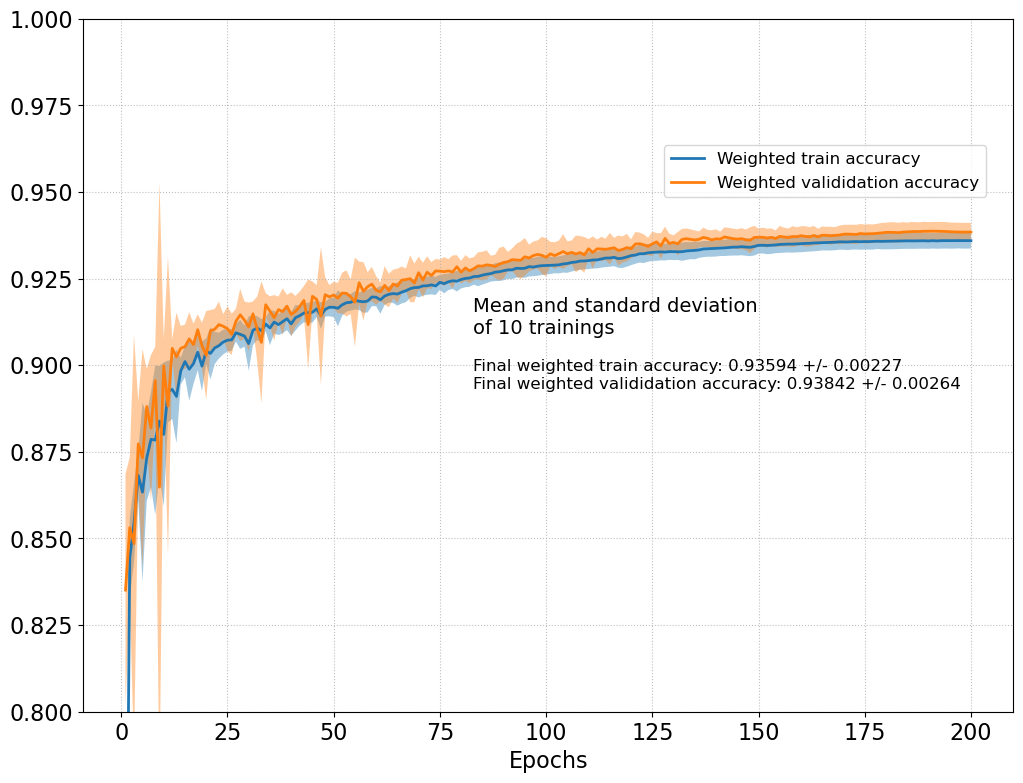

In [10]:
plot_variance_curve([cls_acc_weighted_array, val_cls_acc_weighted_array],
                    ["Weighted train accuracy", "Weighted valididation accuracy"],
                    skip=0,
                    ylim=(0.8, 1),
                    save_path="cls_acc_std.pdf"
                   )